In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
#import glob
import copy
import pandas as pd
#from scipy.fft import fft, fftfreq
#from scipy import signal
#from globals import * 
from sklearn.decomposition import PCA


# DATA LOADING
> Read and modify Momona's below code as needed or just write the code from scratch
## 1: user-defined-gestures.ipynb
> Potentially relevant code, I haven't read through it yet

In [ ]:
# def split_file_types(files,expt_type):
#     return [file for file in files if file.split("_")[2]==expt_type]

def ignore_repeated_files(files):
    files_no_repeats = []
    count = 0
    double_flag = False
    while count < len(files)-1:
        fileNum1 = files[count].split("_")[5]#.split(".")[0]
        fileNum2 = files[count+1].split("_")[5]#.split(".")[0]
        if (fileNum1==fileNum2):
            if files[count].split("_")[2] == files[count+1].split("_")[2]:
                files_no_repeats.append(files[count+1])
                count += 2
                double_flag = True
            else:
                files_no_repeats.append(files[count])
                count +=1
                double_flag = False
        else:
            files_no_repeats.append(files[count])
            count +=1
            double_flag = False
    if double_flag == False:
        files_no_repeats.append(files[-1])
    return files_no_repeats

def minToSec(file):
    datetime = file.split("_")[0][-6:]
    seconds = int(datetime[:2])*3600+int(datetime[2:4])*60 + int(datetime[4:])
    return seconds

def interaction_type(file):
    interaction = file.split("_")[4:6]
    return interaction

def read_and_save_cleaned_data(participantID,n_interpolate=100,bound_size=1e-3):#,df_EMG_exptr_def,df_EMG_usr_def,df_EMG_calib,df_EMG_rehab):
    path = global_path +participantID+"\\"
    save_path = temp_path + participantID + "\\"
    files = os.listdir(path)
    files = copy.deepcopy(files[:-3])
    EMG_files = []
    IMU_files = []
    LeapLeft_files = []
    LeapRight_files = []
    RGBcamera_files = []
    SynchData_files = []

    for file in files:
        if len(file.split("_")) < 4:
            continue
        biosig_type = file.split("_")[3]
        expt_type = file.split("_")[2] # "experimenter-defined, user-defined, calibration, rehab"  
        if biosig_type=="EMG" and expt_type == "experimenter-defined":
            EMG_files.append(file)
        elif biosig_type=="LeapRight" and expt_type != "calibration":
            LeapRight_files.append(file)
        elif biosig_type=="IMU" and expt_type != "calibration":
            IMU_files.append(file)

    EMG_files = sorted(EMG_files,key=lambda file: minToSec(file))   
    iN = 0
    while len(EMG_files) > 100: # for people who didn't do hand trials
        EMG_files = ignore_repeated_files(EMG_files)
        iN += 1
        if iN > 100:
            EMG_files = sorted(EMG_files,key=lambda file: interaction_type(file))
#             print('the number of EMG files is: ',len(EMG_files), "and it should be: ", str(100))
            break;
    EMG_files = sorted(EMG_files,key=lambda file: interaction_type(file))
    iN = 0
    while len(EMG_files) > 100: # for people who didn't do hand trials
        EMG_files = ignore_repeated_files(EMG_files)
        iN += 1
        if iN > 100:
            print('the number of EMG files is: ',len(EMG_files), "and it should be: ", str(100))
            break;

    for ix,file in enumerate(EMG_files):
        split_filename = file.split("_")
        expt_type = split_filename[2] # "experimenter-defined, user-defined, calibration, rehab" 
        gestureID = split_filename[4]
        gestureNum = split_filename[5].split(".")[0]
            # define for user-def, calib, and rehab too
        if expt_type == "calibration":
            continue
        else:
        
            df_EMG = pd.read_csv(path+file,sep="\t",names=['EMG1','EMG2','EMG3','EMG4','EMG5',
                                                           'EMG6','EMG7','EMG8','EMG9','EMG10',
                                                           'EMG11','EMG12','EMG13','EMG14','EMG15',
                                                           'EMG16'],header=None)

            # check if EMG activity is doubled
            if df_EMG["EMG2"].values[2]==df_EMG["EMG2"].values[3]:
                df_EMG = df_EMG.iloc[::2, :] # participant has redundant EMG activity

            # filter raw EMG signals
            df_EMG_filt = df_EMG.apply(rectify_EMG,axis=0)
            time_EMG = np.linspace(0,len(df_EMG)/2000,len(df_EMG)) # TODO CHECK TO SEE IF EMG IS 2000 Hz 

            # compute moving average time x 16 channels
            df_EMG_movavg = df_EMG_filt.apply(movavg_EMG,axis=0)
            # save moving average as csv files
            if not os.path.isdir(temp_path + participantID):
                os.mkdir(temp_path + participantID)
            if not os.path.isdir(save_path+'movavg_files'):
                os.mkdir(save_path+'movavg_files')
            df_EMG_movavg.to_csv(save_path+'movavg_files/' + file[:-4] + "_movavg.csv")
            # PCA time x num_pca_components
            pca = PCA()
            df_EMG_pca = pd.DataFrame(pca.fit_transform(df_EMG_movavg)) # time x num_pca_components

            # save filtered and cleaned EMG data as csv files 
            if not os.path.isdir(save_path+'pca_files'):
                os.mkdir(save_path+'pca_files')
            df_EMG_pca.to_csv(save_path+'pca_files/' + file[:-4] + "_pca.csv")

# Code Outline

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

In [ ]:
# Directories: $M Data Segmented / segmented_filtered_data / PXXX
# The participant IDs that start with P1xx are the participants with disabilities
# FROM GLOBALS:
#pIDs = ['P101','P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
#        'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
#        'P126','P127','P128','P131','P132']
#pIDs_unimpaired = ['P001','P003','P004','P005','P006','P008','P010','P011']
# All filenames and types of data available are in the fnames folder. 
# Headers are labeled. The ID for each IMU and EMG sensor are in the sensor_layout PDF. 

In [ ]:
### TO DO:

# Load data into DataFrame
# Decide on concat/aggregation scheme across the different files --> May need to resample...
## You will have to use np.interp to get the data to be the same number of points for each file, use n=64 datapoints. I [M] have some code to do this if you get stuck. 
# Start PCA: Decide on how to break up data so that we can train a single PCA model and use that on all users/gestures...
# Plot 2D or 3D PCA embeddings

In [ ]:
## SANITY CHECK AFTER LOADING DATA: For one participant, plot all 16 channels of EMG data, similar to Momona's code here:
### Eg revamp Momona's code

muscles=['R_bic','R_tri','R_delt','R_trap','L_bic','L_tri','L_delt','L_trap','R_ext','R_flex','R_thumbOut','R_thumbIn','L_ext','L_flex','L_thumbOut','L_thumbIn']
muscles=['R-bicep','R-tricep','R-deltoid','R-trapezius','L-bicep','L-tricep','L-deltoid',
         'L-trapezius','R-extensors','R-flexors','R-outer-thumb','R-inner-thumb','L-extensors','L-flexors','L-outer-thumb','L-inner-thumb']
time_EMG = np.linspace(0,len(df_EMG)/2000,len(df_EMG))#EMG_filt_one_trial['time']

fig,axs = plt.subplots(4,4,figsize=(20,10),sharex=True, sharey=True)
ch=0
for ix in range(4):
    for iy in range(4):
#         axs[ix,iy].plot(time_EMG,EMG_filt_one_trial[ch]-np.mean(df_EMG[ch]))
        axs[ix,iy].plot(time_EMG,df_EMG[ch],color='#9CDDF9')
        axs[ix,iy].set_title(muscles[ch])#+str(ch+1))
        ch+=1
        if ix==3:
            axs[ix,iy].set_xlabel('time (sec)')
plt.suptitle('raw EMG data for participant with disability')


## Data smashing
- EMG csv files for each gesture performed by each user
- IMU csv files for each gesture performed by each user
- COMPLEXITY: 3 datasets of increasing complexity
    - Try PCA on EMG only first
    - Try PCA on IMU only
    - Try PCA on combined EMG+IMU datasets 

# EXAMPLE USING DUMMY DATA

In [13]:
# This is the PCA exmaple from the scipy documentation

# This is the input data that we are trying to reduce the dimensions of
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# Here, we define that actual PCA object/model, and input the necessary parameters
## n_components is the number of final principal components, or the number of dimensions the output will be
pca = PCA(n_components=2)
# This is where they actually train the PCA model, training it to fit the provided dataset
pca.fit(X)

# Now, apply the trained model to the data:
pca.transform(X)

array([[ 1.38340578,  0.2935787 ],
       [ 2.22189802, -0.25133484],
       [ 3.6053038 ,  0.04224385],
       [-1.38340578, -0.2935787 ],
       [-2.22189802,  0.25133484],
       [-3.6053038 , -0.04224385]])

In [27]:
# Five gesture csv files from one participant
## Note that the real EMG data won't have the same number of rows, most likely... do interp or something on rows
dummy_EMG_df1 = pd.DataFrame(np.random.rand(31, 16))
dummy_EMG_df2 = pd.DataFrame(np.random.rand(31, 16))
dummy_EMG_df3 = pd.DataFrame(np.random.rand(31, 16))
dummy_EMG_df4 = pd.DataFrame(np.random.rand(31, 16))
dummy_EMG_df5 = pd.DataFrame(np.random.rand(31, 16))
## ^Really you ought to load in the csv file as a pandas dataframe here...

dummy_EMG_df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.240123,0.582291,0.881592,0.109169,0.376836,0.360559,0.457950,0.658822,0.834527,0.839306,0.122871,0.289708,0.663672,0.527640,0.293054,0.040776
1,0.019973,0.727560,0.423491,0.617146,0.427088,0.318155,0.978740,0.314689,0.002192,0.460612,0.721208,0.709990,0.245525,0.100155,0.359213,0.451019
2,0.343569,0.521533,0.337950,0.849048,0.256217,0.484486,0.651757,0.214065,0.687789,0.113213,0.871107,0.527412,0.163007,0.629690,0.243487,0.705862
3,0.791442,0.524649,0.487910,0.507476,0.213645,0.045807,0.443563,0.601909,0.149047,0.198923,0.494192,0.945783,0.053837,0.916119,0.662799,0.851787
4,0.203158,0.722233,0.763593,0.443024,0.463426,0.568855,0.583147,0.280035,0.881352,0.083293,0.380916,0.709153,0.278709,0.482206,0.259029,0.304663


In [31]:
# Horizontally concat the different gestures
## Would repeat this process for all gestures, for all users...
full_data_df = pd.concat([dummy_EMG_df1, dummy_EMG_df2, dummy_EMG_df3, dummy_EMG_df4, dummy_EMG_df5], axis=1)
print(f"Here, we concat such that the rows are the time dimension and the columns are the EMG channels; full_data_df.shape: {full_data_df.shape}")

Here, we concat such that the rows are the time dimension and the columns are the EMG channels; full_data_df.shape: (31, 80)


In [29]:
pca = PCA(n_components=2)
pca.fit(full_data_df)

PCA(n_components=2)

In [30]:
# Now, apply the trained model to the data:
EMG_2D_df = pd.DataFrame(pca.transform(full_data_df))
print(EMG_2D_df.shape)
EMG_2D_df.head()

(31, 2)


,0,1
0,-0.712437,-0.169177
1,-0.056394,0.053417
2,1.161776,-0.420315
3,-0.394097,-0.208514
4,0.822973,-0.551881


In [22]:
# Now, apply the trained model to each gesture:
EMG1_2D_df = pd.DataFrame(pca.transform(dummy_EMG_df1))
EMG1_2D_df

ValueError: X has 16 features, but PCA is expecting 80 features as input.

So PCA can't be trained on data of one size (eg n number of columns) and tested on another (eg m number of columns) --> e.g., we can't train one giant PCA model and then apply it to each user/gesture individually
> Thus, we should just train it on the entire dataset (note that .fit() autoapplies it to the training dataset, allegedly), and then break up the resulting dataframe accordingly (eg break it up by user/gesture)

In [32]:
# Vertically concatting now
full_data_df = pd.concat([dummy_EMG_df1, dummy_EMG_df2, dummy_EMG_df3, dummy_EMG_df4, dummy_EMG_df5])
print(f"Here, we concat such that the rows are the time dimension and the columns are the EMG channels; full_data_df.shape: {full_data_df.shape}")

Here, we concat such that the rows are the time dimension and the columns are the EMG channels; full_data_df.shape: (155, 16)


In [34]:
pca = PCA(n_components=2)
pca.fit(full_data_df)
# Now, apply the trained model to full dataset!:
EMG_2D_full_df = pd.DataFrame(pca.transform(full_data_df))
print(EMG_2D_full_df.shape)
EMG_2D_full_df.head()

(155, 2)


,0,1
0,0.311358,-0.263927
1,-0.703078,0.342485
2,0.010484,0.667052
3,-0.181803,0.335924
4,-0.066217,0.114832


We know a priori that our (dummy) gestures have 31 rows of time data (in the real case, probably need to resample all gestures to 64 via interp), and thus we can break up the dataframe into our original 5 gestures, AKA every 31 rows 

In [39]:
# Iterate over 5 gestures to create 5 smaller dataframes (eg one for each gesture)
num_gestures = 5
rows_per_dataframe = 31
smaller_dfs = []  # List of smaller dataframes

for i in range(num_gestures):
    # Calculate start and end indices for slicing
    start_index = i * rows_per_dataframe
    end_index = start_index + rows_per_dataframe
    
    # Slice the original DataFrame and append the smaller DataFrame to the list
    smaller_dfs.append(EMG_2D_full_df.iloc[start_index:end_index].reset_index(drop=True))

for small_df in smaller_dfs:
    print(small_df.shape)
    print(small_df.head())
    print()

(31, 2)
          0         1
0  0.311358 -0.263927
1 -0.703078  0.342485
2  0.010484  0.667052
3 -0.181803  0.335924
4 -0.066217  0.114832

(31, 2)
          0         1
0 -0.414492 -0.297966
1 -0.157066 -0.080156
2 -0.339682  0.146801
3  0.132040  0.614264
4 -0.177842 -0.035357

(31, 2)
          0         1
0 -0.299408 -0.287814
1  0.109356 -0.281614
2  0.624971 -0.076653
3  0.281077  0.100287
4  0.125105  0.001877

(31, 2)
          0         1
0  0.125465 -0.163273
1 -0.172280  0.223089
2  0.304888 -0.268191
3  0.377944  0.384058
4  0.188264  0.843972

(31, 2)
          0         1
0  0.162233  0.098956
1  0.261022  0.551543
2 -0.206221 -0.024214
3  0.391820  0.159354
4  0.146296 -0.051515



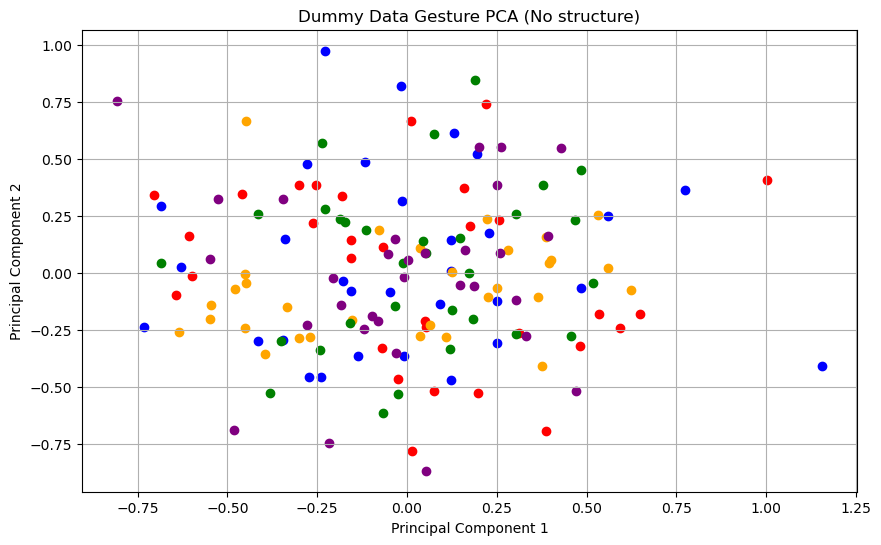

In [46]:
# Now do some plotting stuff, visualize results in matplotlib:
color_str_lst = ['red', 'blue', 'orange', 'green', 'purple']

# Visualize data points
plt.figure(figsize=(10, 6))
for i in range(num_gestures):
    plt.scatter(smaller_dfs[i].iloc[:, 0], smaller_dfs[i].iloc[:, 1], color=color_str_lst[i])#, s=50, alpha=0.5) #EMG_2D_full_df
plt.title('Dummy Data Gesture PCA (No structure)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


Since I used dummy data, we knew ahead of time that there would be no structure (all data is randomly generated according to the same function)